# Precipitation analysis

## Necessary libraries

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import pandas as pd
import seaborn as sn

## Datasets

In [2]:
# define main paths for observations and reanalysis + for simulations
obs_path = '/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/'
sim_path = '/media/irene/Elements/wrf_micro/'

In [3]:
# Reanalysis and observations
ds_prERA = xr.open_dataset(f'{obs_path}/ERA5-pr-acpr-t2m-olr-MCScase.nc') #with range lat:25-42, lon:70-114 and days 2008-July 14 to 24
ds_prIMERG = xr.open_dataset(f'{obs_path}/gpm_PP_mcs20080714-20080724.nc') 
ds_prGLDAS = xr.open_dataset(f'{obs_path}/GLDAS.nc') #it's not hourly, it's every 3 hours
ds_prAPHRO = xr.open_dataset(f'{obs_path}/APHRO_MA_025deg_V1801R1.2008.nc')
ds_prMSWEP = xr.open_dataset(f'{obs_path}/P-MSWEP-MCS.nc') #it's every 3 hours + whole world

# WRF simulations -> already regridded to ERA5 2d spatial resolution and cut for right time
ds_rprtho = xr.open_dataset(f'{sim_path}/Thompson/reg_wrftho_PTO-16to24.nc')
ds_rprmor = xr.open_dataset(f'{sim_path}/Morrison/reg_wrfmor_PTO-16to24.nc')
ds_rprcam = xr.open_dataset(f'{sim_path}/CAM/reg_wrfcam_PTO-16to24.nc')
ds_rprylin = xr.open_dataset(f'{sim_path}/Ylin/reg_wrfylin_PTO-16to24.nc')
ds_rprwdm7 = xr.open_dataset(f'{sim_path}/WDM7/reg_wrfwdm7_PTO-16to24.nc')
ds_rprwdm6 = xr.open_dataset(f'{sim_path}/WDM6/reg_wrfwdm6_PTO-16to24.nc')

## Cut temporal and spatial domain

In [4]:
# Set start and end
start = '2008-07-16T00:00:00.000000000'
end = '2008-07-24T23:00:00.000000000'
end_daily = '2008-07-25T00:00:00.000000000' # for daily dataset

In [5]:
# Define days
days = ['2008-07-16', '2008-07-17','2008-07-18', '2008-07-19','2008-07-20',
        '2008-07-21','2008-07-22', '2008-07-23', '2008-07-24']

In [6]:
# Cut right time range (WRF time range is already 16 to 24 July)
ds_prERA = ds_prERA.sel(time=slice(start, end))
ds_prGLDAS = ds_prGLDAS.sel(time=slice(start, end))
ds_prAPHRO = ds_prAPHRO.sel(time=slice(start, end_daily))
ds_prMSWEP = ds_prMSWEP.sel(time=slice(start, end))

In [7]:
# Set latitude and longitude
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114

In [8]:
# Cut right spatial domain (Sichuan Basin)
ds_prERAc = ds_prERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prGLDASc = ds_prGLDAS.sel(lat=slice(lat1-0.2,lat2+0.2), lon=slice(lon1-0.2,lon2+0.2)) #+-0.2 because of spatial resolution of dataset
ds_prAPHROc = ds_prAPHRO.sel(lat=slice(lat1-0.2,lat2+0.2), lon=slice(lon1-0.2,lon2+0.2))
ds_prMSWEPc = ds_prMSWEP.sel(lat=slice(lat2+0.2,lat1-0.2), lon=slice(lon1-0.2,lon2+0.2))

ds_prIMERG['lat'], ds_prIMERG['lon'] = ds_prIMERG.latitude.values, ds_prIMERG.longitude.values # need this before regridding IMERG
ds_prIMERGc = ds_prIMERG.sel(lat=slice(lat1,lat2), lon=slice(lon1,lon2))

ds_rprthoc = ds_rprtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprmorc = ds_rprmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprcamc = ds_rprcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprylinc = ds_rprylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprwdm7c = ds_rprwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_rprwdm6c = ds_rprwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

In [9]:
# Regrid 
# List ERA5 2d spatial points
lati, longi = ds_prERAc.latitude.values.flatten(), ds_prERAc.longitude.values.flatten()

ds_rprGLDASc =  ds_prGLDASc.sel(lat=lati, lon=longi, method="nearest")
ds_rprAPHROc =  ds_prAPHROc.sel(lat=lati, lon=longi, method="nearest")
ds_rprMSWEPc =  ds_prMSWEPc.sel(lat=lati, lon=longi, method="nearest")
ds_rprIMERGc = ds_prIMERGc.sel(lat=lati, lon=longi, method="nearest")

## Compute precipitation rate and accumulated precipitation time series

In [10]:
# Calculate spatial mean of (*24 to convert mm/hour in mm/day, *86400 to have in mm/day instead of kg/m2s)
mean_rprthoc = (ds_rprthoc.PREC_ACC_NC*24).mean(dim=('latitude', 'longitude'))
mean_rprmorc = (ds_rprmorc.PREC_ACC_NC*24).mean(dim=('latitude', 'longitude'))
mean_rprcamc = (ds_rprcamc.PREC_ACC_NC*24).mean(dim=('latitude', 'longitude'))
mean_rprylinc = (ds_rprylinc.PREC_ACC_NC*24).mean(dim=('latitude', 'longitude'))
mean_rprwdm7c = (ds_rprwdm7c.PREC_ACC_NC*24).mean(dim=('latitude', 'longitude'))
mean_rprwdm6c = (ds_rprwdm6c.PREC_ACC_NC*24).mean(dim=('latitude', 'longitude'))

mean_prERAc = (ds_prERAc.mtpr*86400).mean(dim=('latitude', 'longitude'))
mean_rprGLDASc = (ds_rprGLDASc.Rainf_f_tavg*86400).mean(dim=('lat', 'lon'))
mean_rprAPHROc = (ds_rprAPHROc.precip).mean(dim=('lat', 'lon'))
mean_rprMSWEPc = (ds_rprMSWEPc.precipitation*8).mean(dim=('lat', 'lon'))

mean_rprIMERGc = (ds_prIMERGc['var'][0][2:11]).mean(dim=('lat', 'lon'))*24 #*24 to convert in mm/day
#since it's divided in years, days and hours per day, i need an array to do the graph with all the hours
rprIMERGc = np.zeros((9,24))
for m in range(0, 9): #9 days
    for i in range(0, 24):
      rprIMERGc[m][i] = mean_rprIMERGc[m][i];
#concatenate daily averages into one array
rprIMERGc = np.concatenate((rprIMERGc[0], rprIMERGc[1], rprIMERGc[2], rprIMERGc[3], rprIMERGc[4], rprIMERGc[5], rprIMERGc[6], rprIMERGc[7], rprIMERGc[8]))

In [11]:
# Linear interpolation of GLDAS data (to have hourly data instead of every 3 hours)
newtime=np.arange(0,216,1)
oldtime=np.arange(0,216,3)
new_rprGLDASc = np.interp(newtime, oldtime, mean_rprGLDASc.values)
new_rprMSWEPc = np.interp(newtime, oldtime, mean_rprMSWEPc.values)

In [12]:
# Calculate daily mean and then plot 10 points
rgroupsc = [[mean_rprthoc[x:x+24] for x in range(0, len(mean_rprthoc), 24)], [mean_rprmorc[x:x+24] for x in range(0, len(mean_rprmorc), 24)], [mean_rprcamc[x:x+24] for x in range(0, len(mean_rprcamc), 24)], [mean_rprylinc[x:x+24] for x in range(0, len(mean_rprylinc), 24)], [mean_rprwdm7c[x:x+24] for x in range(0, len(mean_rprwdm7c), 24)], [mean_rprwdm6c[x:x+24] for x in range(0, len(mean_rprwdm6c), 24)], [mean_prERAc[x:x+24] for x in range(0, len(mean_prERAc), 24)],  [rprIMERGc[x:x+24] for x in range(0, len(rprIMERGc), 24)], [new_rprGLDASc[x:x+24] for x in range(0, len(new_rprGLDASc), 24)], [new_rprMSWEPc[x:x+24] for x in range(0, len(new_rprMSWEPc), 24)]]

# Simple math to calculate the means
ravgdailyc = np.zeros((10,9))
for m in range(0,10): #number of datasets
 for i in range(0,9): #nine days
    ravgdailyc[m][i] = sum(rgroupsc[m][i])/24

In [13]:
# New variable to compute accumulated precipitation from hourly precip rates
# make loop for WRF and ERA5
ds = [mean_rprthoc/24, mean_rprmorc/24, mean_rprcamc/24, mean_rprylinc/24, mean_rprwdm7c/24, mean_rprwdm6c/24, mean_prERAc/24] #/24 to have mm/hour
racpr = np.zeros((9,216))
for m in range(0, len(ds)):
    for i in range(0, 216):
     racpr[m][i] = racpr[m][i-1] + ds[m][i].values; #to compute accumulated precipitation

# Acc precip obs
rac_prIMERGc = np.zeros(216)
rac_prIMERGc = np.cumsum(rprIMERGc/24)
racpr_GLDASc = np.zeros(216)
racpr_GLDASc = np.cumsum(new_rprGLDASc/24) #/24 to have mm/hour - hourly accumulated pr
racpr_APHROc = np.zeros(216)
racpr_APHROc = np.cumsum(mean_rprAPHROc)
racpr_APHROc[0] = 0 #to make the acpr start from 0 cause APHRO is daily
racpr_MSWEPc = np.zeros(216)
racpr_MSWEPc = np.cumsum(new_rprMSWEPc/24)

In [14]:
# Select only now the right days cause for APHRO accumulated precipitation you use 25 July point (instead of 24T23)
mean_rprAPHROc = mean_rprAPHROc[0:9]

## Compute precipitation rate and accumulated precipitation maps

In [15]:
# Mean precipitation rate over XTIME
meant_rprthoc = (ds_rprthoc.PREC_ACC_NC*24).mean(dim='XTIME') #to have values in mm/day
meant_rprmorc = (ds_rprmorc.PREC_ACC_NC*24).mean(dim='XTIME')
meant_rprcamc = (ds_rprcamc.PREC_ACC_NC*24).mean(dim='XTIME')
meant_rprylinc = (ds_rprylinc.PREC_ACC_NC*24).mean(dim='XTIME')
meant_rprwdm7c = (ds_rprwdm7c.PREC_ACC_NC*24).mean(dim='XTIME')
meant_rprwdm6c = (ds_rprwdm6c.PREC_ACC_NC*24).mean(dim='XTIME')

meant_prERAc = (ds_prERAc.mtpr*86400).mean(dim='time')
meant_rprGLDASc = (ds_rprGLDASc.Rainf_f_tavg*86400).mean(dim='time')
meant_rprAPHROc = (ds_rprAPHROc.precip).mean(dim='time')
meant_rprMSWEPc = (ds_rprMSWEPc.precipitation*8).mean(dim='time')
meant_rprIMERGc = (ds_rprIMERGc['var'][0][2:11]).mean(dim=('days', 'hours'))*24
meant_rprIMERGc = meant_rprIMERGc.transpose(transpose_coords=True, missing_dims='raise') # to have lat, lon in the right order

## Plot timeseries and maps

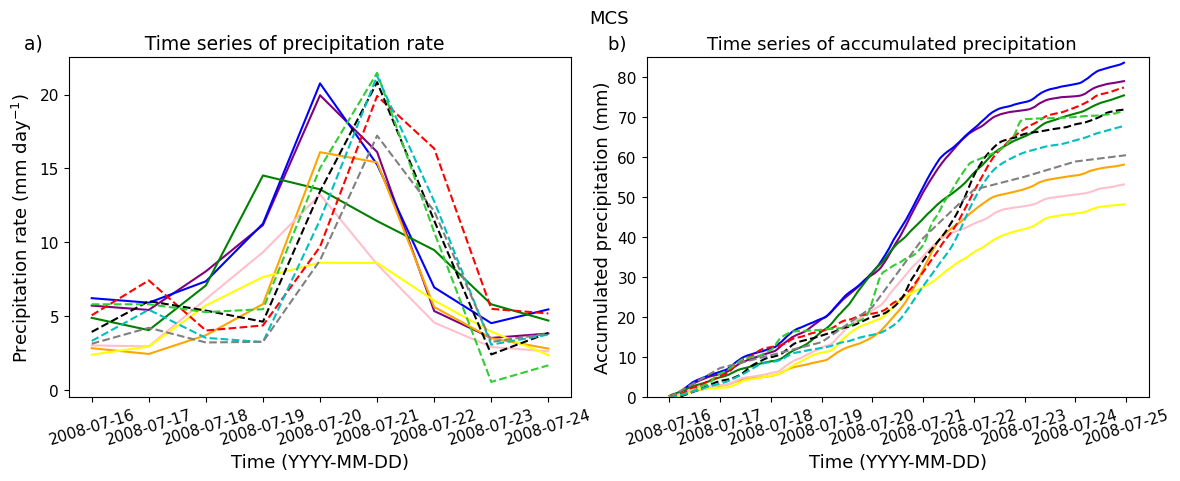

In [16]:
# Timeseries
nrows, ncols = 1,2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=13, y=1.07)

# precipitation rate
axs[0].plot(days, ravgdailyc[0], color='purple', label='Thompson')
axs[0].plot(days, ravgdailyc[1], color='blue', label='Morrison')
axs[0].plot(days, ravgdailyc[2], color='green', label='CAM')
axs[0].plot(days, ravgdailyc[3], color='orange', label='Ylin')
axs[0].plot(days, ravgdailyc[4], color='pink', label='WDM7')
axs[0].plot(days, ravgdailyc[5], color='yellow', label='WDM6')
axs[0].plot(days, ravgdailyc[6], color='r', linestyle='dashed' ,label='ERA5')
axs[0].plot(days, ravgdailyc[7], color='k', linestyle='dashed', label='IMERG')
axs[0].plot(days, ravgdailyc[8], color='limegreen', linestyle='dashed', label='GLDAS')
axs[0].plot(days, ravgdailyc[9], color='c', linestyle='dashed', label='MSWEP')
axs[0].plot(days, mean_rprAPHROc.values, color='grey', linestyle='dashed', label='APHRODITE')

axs[0].tick_params(axis='y', labelsize=11)
axs[0].tick_params(axis='x', rotation=17, labelsize=11)
axs[0].set_title('a)                 Time series of precipitation rate', fontsize=13.5, x=0.33)
axs[0].set_ylabel(r'Precipitation rate (mm day$^{-1}$)', fontsize=13)
axs[0].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)

# accumulated precipitation
axs[1].plot(ds_prERA.time, racpr[0], color='purple', label='Thompson')
axs[1].plot(ds_prERA.time, racpr[1], color='blue', label='Morrison')
axs[1].plot(ds_prERA.time, racpr[2], color='green', label='CAM')
axs[1].plot(ds_prERA.time, racpr[3], color='orange', label='Ylin')
axs[1].plot(ds_prERA.time, racpr[4], color='pink', label='WDM7')
axs[1].plot(ds_prERA.time, racpr[5], color='yellow', label='WDM6')
axs[1].plot(ds_prERA.time, racpr[6], color='r', linestyle='dashed', label='ERA5')
axs[1].plot(ds_prERA.time, rac_prIMERGc, linestyle='dashed',color='k', label='IMERG')
axs[1].plot(ds_prERA.time, racpr_GLDASc, linestyle='dashed',color='limegreen', label='GLDAS')
axs[1].plot(ds_prERA.time, racpr_MSWEPc, linestyle='dashed',color='c', label='MSWEP')
axs[1].plot(racpr_APHROc.time, racpr_APHROc, linestyle='dashed',color='grey', label='APHRODITE')

#axs[1].legend(loc='upper right', ncol=6, bbox_to_anchor=(0.75, -0.22), fontsize=12)
axs[1].set_ylim(0, 85)
axs[1].tick_params(axis='y', labelsize=11)
axs[1].tick_params(axis='x', rotation=17, labelsize=11)
axs[1].set_title('b)              Time series of accumulated precipitation', fontsize=13, x=+0.39)
axs[1].set_ylabel('Accumulated precipitation (mm)', fontsize=13)
axs[1].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.15, hspace=0.25)

#plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-time-mcs.png', dpi=400, bbox_inches='tight');
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/p-time-mcs-svg.svg', format='svg', dpi=400, bbox_inches='tight')


<Axes: >

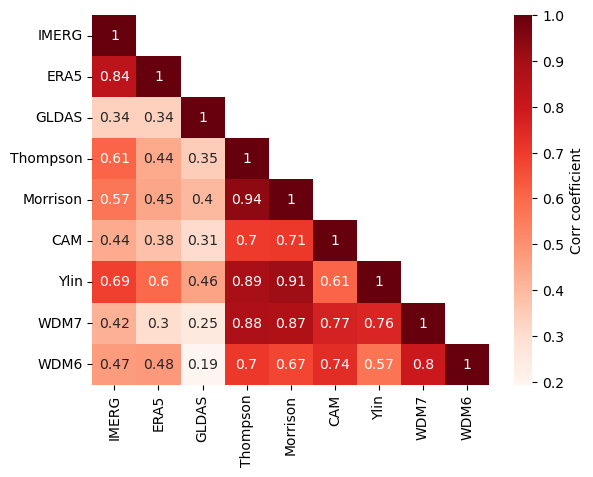

In [17]:
#datasets for Sichuan Basin
m = rprIMERGc
m0 = mean_prERAc.values
m00 = new_rprGLDASc
m1 = mean_rprthoc.values   
m2 = mean_rprmorc.values  
m3 = mean_rprcamc.values    
m4 = mean_rprylinc.values    
m5 = mean_rprwdm7c.values   
m6 = mean_rprwdm6c.values    

data = {'IMERG': m, 'ERA5': m0,'GLDAS': m00, 'Thompson': m1, 'Morrison': m2, 'CAM':m3, 'Ylin':m4 , 'WDM7':m5, 'WDM6':m6 }
df = pd.DataFrame(data)
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Want diagonal Elements2 as well
mask[np.diag_indices_from(mask)] = False

sn.heatmap(corr_matrix, annot=True, cmap='Reds', mask=mask, cbar_kws={'label': 'Corr coefficient'})

*** correlation without daily cycle

In [18]:
# Decycling: do the mean for all the means and use that as a reference
# Precipitation

mean1 = (rprIMERGc + mean_prERAc.values + mean_rprthoc + mean_rprmorc + mean_rprcamc + mean_rprylinc + mean_rprwdm7c + mean_rprwdm7c)/8

# Compute the difference: precipitation decycled
dec_prthoc = (mean_rprthoc.values - mean1.values )
dec_prmorc = (mean_rprmorc.values - mean1.values )
dec_prcamc = (mean_rprcamc.values - mean1.values )
dec_prylinc = (mean_rprylinc.values - mean1.values )
dec_prwdm7c = (mean_rprwdm7c.values - mean1.values )
dec_prwdm6c = (mean_rprwdm6c.values - mean1.values)
dec_prERAc = (mean_prERAc.values - mean1.values )
dec_prIMERGc = (rprIMERGc - mean1.values )

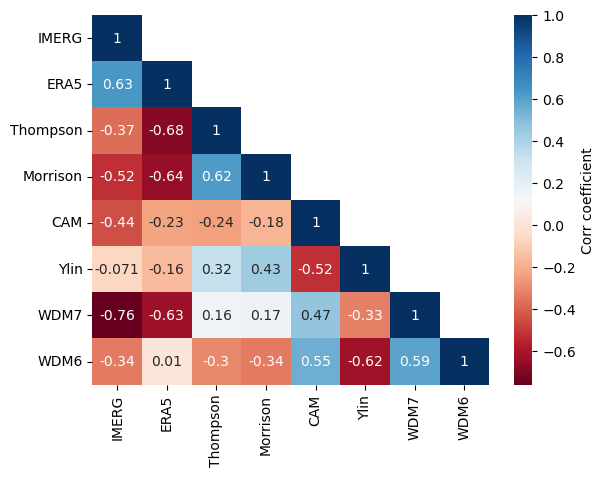

In [19]:
#datasets for Nam Co
m = dec_prIMERGc
m0 = dec_prERAc
m1 = dec_prthoc  
m2 = dec_prmorc  
m3 = dec_prcamc    
m4 = dec_prylinc    
m5 = dec_prwdm7c   
m6 = dec_prwdm6c    

data = {'IMERG': m, 'ERA5': m0, 'Thompson': m1, 'Morrison': m2, 'CAM':m3, 'Ylin':m4 , 'WDM7':m5, 'WDM6':m6 }
df = pd.DataFrame(data)
corr_matrix = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Want diagonal Elements2 as well
mask[np.diag_indices_from(mask)] = False

sn.heatmap(corr_matrix, annot=True, cmap='RdBu', mask=mask, cbar_kws={'label': 'Corr coefficient'})

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/corr_dec_mcs.png', dpi=400, bbox_inches='tight');

In [20]:
# Add elevation data to have TP profile
elevation_data =  xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/script/scripts29May/geopotential.nc')
height = elevation_data/9.81
height = height.sel(latitude=slice(35,26), longitude=slice(100,114))

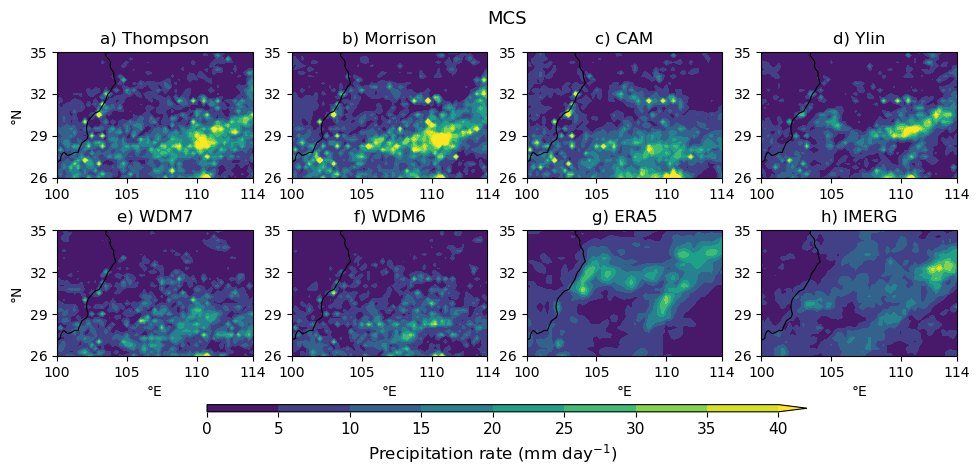

In [21]:
#datasets
ds = [meant_rprthoc, meant_rprmorc, meant_rprcamc, meant_rprylinc, meant_rprwdm7c, meant_rprwdm6c, meant_prERAc, meant_rprIMERGc]
titl=['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5', 'h) IMERG']
#colormap
cmap  = plt.cm.viridis 
#set clevels
clevs=np.arange(0,41,5)

#create figure
nrows, ncols = 2,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10,4), linewidth=0)
axs = axs.flatten()
fig.suptitle('MCS', fontsize=13, y=1.01)

# loop for datasets
for i in range (0, 8):
 cs = axs[i].contourf(meant_prERAc.longitude.values, meant_prERAc.latitude.values, ds[i], clevs, cmap=cmap, extend='max', antialiased=False)
 axs[i].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
 axs[i].set_title(f'{(3*titl)[i]}', fontsize = 12) 
 axs[i].set_xticks([100,105,110,114])
 axs[i].set_yticks([26,29,32,35])
 axs[i].tick_params(axis='x', labelsize=10)  
 axs[i].tick_params(axis='y', labelsize=10)
 axs[0].set_ylabel('°N', fontsize=10)
 axs[4].set_ylabel('°N', fontsize=10)
 axs[4].set_xlabel('°E', fontsize=10)
 axs[5].set_xlabel('°E', fontsize=10)
 axs[6].set_xlabel('°E', fontsize=10)
 axs[7].set_xlabel('°E', fontsize=10)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.005, 0.6, 0.018])
cbar=fig.colorbar(cs, cax=cbar_ax, drawedges=False, orientation='horizontal')
cbar.set_label(r'Precipitation rate (mm day$^{-1}$)', fontsize = 12)
cbar.ax.tick_params(labelsize=11) 

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-maps-mcs.png', dpi=400, bbox_inches='tight');


/tmp/ipykernel_5494/2234787809.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/2234787809.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/2234787809.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/2234787809.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/2234787809.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.col

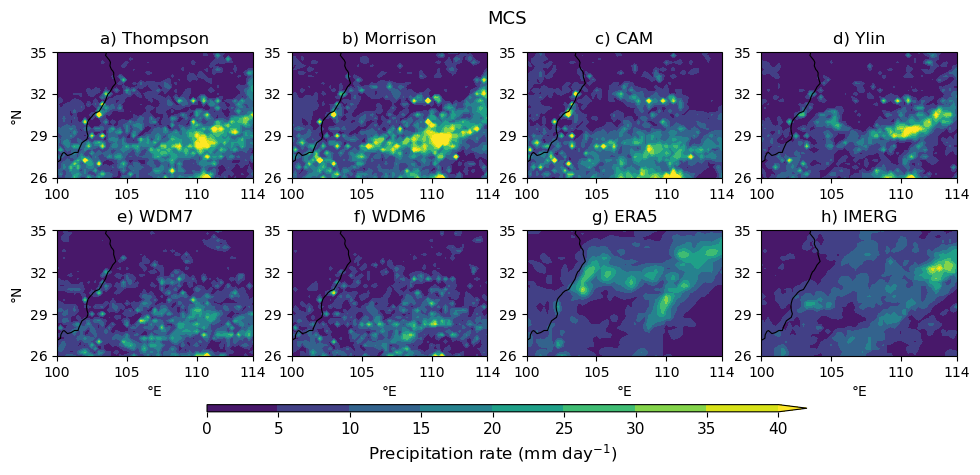

In [25]:
### FIX THIS

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# datasets
ds = [meant_rprthoc, meant_rprmorc, meant_rprcamc, meant_rprylinc,
      meant_rprwdm7c, meant_rprwdm6c, meant_prERAc, meant_rprIMERGc]
titl = ['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin',
        'e) WDM7', 'f) WDM6', 'g) ERA5', 'h) IMERG']

# colormap and levels
cmap = plt.cm.viridis
clevs = np.arange(0, 41, 5)

# create figure
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10, 4), linewidth=0)
axs = axs.flatten()
fig.suptitle('MCS', fontsize=13, y=1.01)

# plotting loop
for i in range(8):
    cs = axs[i].contourf(meant_prERAc.longitude.values,
                         meant_prERAc.latitude.values,
                         ds[i],
                         clevs, cmap=cmap,
                         extend='max', antialiased=False,
                         transform=ccrs.PlateCarree())

    # Rasterize just the color field (important!)
    for col in cs.collections:
        col.set_rasterized(True)

    axs[i].contour(height.z.longitude.values, height.z.latitude.values,
                   height.z[0], levels=[3000], colors='black', linewidths=0.8,
                   transform=ccrs.PlateCarree())

    axs[i].set_title(f'{titl[i]}', fontsize=12)
    axs[i].set_xticks([100, 105, 110, 114])
    axs[i].set_yticks([26, 29, 32, 35])
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)

# label axes
for i in [0, 4]:
    axs[i].set_ylabel('°N', fontsize=10)
for i in [4, 5, 6, 7]:
    axs[i].set_xlabel('°E', fontsize=10)

# colorbar
cbar_ax = fig.add_axes([0.2, 0.005, 0.6, 0.018])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', drawedges=False)
cbar.set_label(r'Precipitation rate (mm day$^{-1}$)', fontsize=12)
cbar.ax.tick_params(labelsize=11)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05,
                    right=0.95, wspace=0.2, hspace=0.1)
cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)
# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/p-maps-mcs-svg.svg',
            format='svg', dpi=400, bbox_inches='tight')


/tmp/ipykernel_5494/4183511144.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/4183511144.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/4183511144.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/4183511144.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.collections:
/tmp/ipykernel_5494/4183511144.py:21: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for col in cs.col

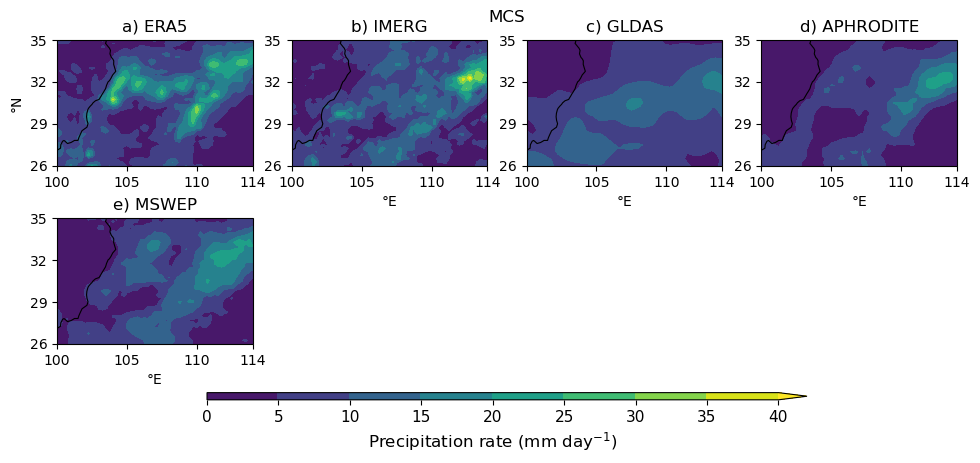

In [28]:
# observation based and reanalysis datasets
ds = [meant_prERAc, meant_rprIMERGc, meant_rprGLDASc, meant_rprAPHROc, meant_rprMSWEPc]
titl=['a) ERA5', 'b) IMERG', 'c) GLDAS', 'd) APHRODITE', 'e) MSWEP']
#colormap
cmap  = plt.cm.viridis 
#set clevels
clevs=np.arange(0,41,5)

#create figure
nrows, ncols = 2,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10,4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=12, y=0.98)


#set anomalies
for i in range (0, 5):
 cs = axs[i].contourf(ds[0].longitude.values, ds[0].latitude.values, ds[i], clevs, cmap=cmap, extend='max')

 # Rasterize just the color field (important!)
 for col in cs.collections:
    col.set_rasterized(True)
    
 axs[i].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
 axs[i].set_title(f'{(3*titl)[i]}', fontsize = 12) 
 axs[i].set_xticks([100,105,110,114])
 axs[i].set_yticks([26,29,32,35])
 axs[i].tick_params(axis='x', labelsize=10)  
 axs[i].tick_params(axis='y', labelsize=10)
 axs[0].set_ylabel('°N', fontsize=10)
 axs[i+1].set_xlabel('°E', fontsize=10)
 axs[5].axis('off')
 axs[6].axis('off')
 axs[7].axis('off')

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.005, 0.6, 0.018])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'Precipitation rate (mm day$^{-1}$)', fontsize = 12)
cbar.ax.tick_params(labelsize=11)
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)

cbar.solids.set_edgecolor("face")
cbar.solids.set_rasterized(True)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-maps-mcs-appendix.png', dpi=400, bbox_inches='tight');
# Save to SVG
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission_svg/p-maps-mcs-appendix.svg',
            format='svg', dpi=400, bbox_inches='tight')

## Taylor diagram for space

In [21]:
# Define everything to do Taylor diagrams:
class TaylorDiagram(object):
    """
    Taylor diagram.

    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """

    def __init__(self, refstd,
                 fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        """
        Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using `mpl_toolkits.axisartist.floating_axes`.

        Parameters:

        * refstd: reference standard deviation to be compared to
        * fig: input Figure or None
        * rect: subplot definition
        * label: reference label
        * srange: stddev axis extension, in units of *refstd*
        * extend: extend diagram to negative correlations
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation

        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            # Diagram extended to negative correlations
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            # Diagram limited to positive correlations
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

        # Standard deviation axis extent (in units of reference stddev)
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd

        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1)

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")   # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom")  # "X axis"
        ax.axis["left"].label.set_text("Standard deviation")

        ax.axis["right"].set_axis_direction("top")    # "Y-axis"
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction(
            "bottom" if extend else "left")

        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)          # Unused

        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates

        # Add reference point and stddev contour
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """
        Add sample (*stddev*, *corrcoeff*) to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """

        l, = self.ax.plot(np.arccos(corrcoef), stddev,
                          *args, **kwargs)  # (theta, radius)
        self.samplePoints.append(l)

        return l

    def add_grid(self, *args, **kwargs):
        """Add a grid."""

        self._ax.grid(*args, **kwargs)

    def add_contours(self, levels=5, **kwargs):
        """
        Add constant centered RMS difference contours, defined by *levels*.
        """

        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax),
                             np.linspace(0, self.tmax))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))

        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)

        return contours

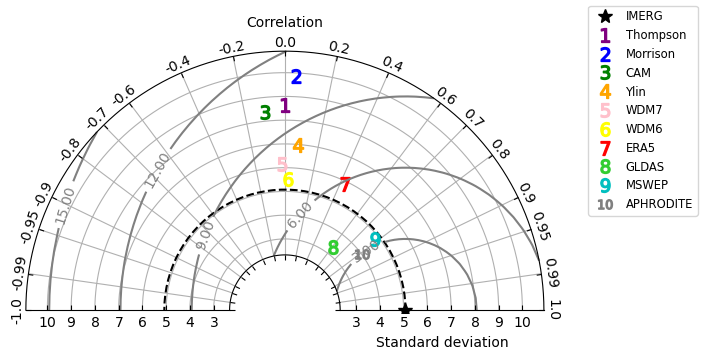

In [22]:
def taylorpr():
    """Display a Taylor diagram in a separate axis."""

    # Reference dataset ERA5
#    x = meant_prERAc.time.values
    data = meant_rprIMERGc.values.flatten()
    refstd = data.std(ddof=1)    # Reference standard deviation

    # datasets: WRF simulations, IMERG and GLDAS
    m1 = meant_rprthoc.values.flatten()  
    m2 = meant_rprmorc.values.flatten() 
    m3 = meant_rprcamc.values.flatten()  
    m4 = meant_rprylinc.values.flatten()
    m5 = meant_rprwdm7c.values.flatten()
    m6 = meant_rprwdm6c.values.flatten()
    m7 = meant_prERAc.values.flatten()
    m8 = meant_rprGLDASc.values.flatten()
    m9 = meant_rprMSWEPc.values.flatten()
    m10 = meant_rprAPHROc.values.flatten()
    
    # Compute stddev and correlation coefficient of datasets
    samples = np.array([ [m.std(ddof=1), np.corrcoef(data, m)[0, 1]]
                         for m in (m1, m2, m3, m4, m5, m6, m7, m8, m9, m10)])

    fig = plt.figure(figsize=(15, 3.5))

    # dynamic range
    all_stddevs = [m.std(ddof=1) for m in [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]]
    min_std = min(all_stddevs)
    max_std = max(all_stddevs)

    # Add some buffer (20%) around the range
    buffer = 0.2 * refstd

    srange = ((min_std - buffer) / refstd, (max_std + buffer) / refstd)
    
    # Taylor diagram
    dia = TaylorDiagram(refstd, fig=fig, rect=122, label="IMERG",
                        srange=srange, extend=True)

    colors=['purple', 'blue', 'green', 'orange', 'pink', 'yellow', 'red', 'limegreen', 'c', 'grey']
    datasets=['Thompson', 'Morrison', 'CAM', 'Ylin', 'WDM7', 'WDM6', 'ERA5', 'GLDAS', 'MSWEP', 'APHRODITE']
    
    # Add the datasets to Taylor diagram
    for i, (stddev, corrcoef) in enumerate(samples):
        dia.add_sample(stddev, corrcoef,
                       marker='$%d$' % (i+1), ms=10, ls='',
                       mfc=colors[i], mec=colors[i],
                       label=datasets[i])

    # Add grid
    dia.add_grid()

    # Add RMS contours, and label them
    contours = dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    
    # Add a figure legend
    fig.legend(dia.samplePoints,
               [ p.get_label() for p in dia.samplePoints ],
               numpoints=1, prop=dict(size='small'), loc='upper right')

    return dia


if __name__ == '__main__':

    dia = taylorpr()

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/taylor-mcs.png', dpi=400, bbox_inches='tight');

## Precipitation ensemble time series

In [23]:
# Assuming all ravgdailyc[i] arrays have the same time axis (e.g., XTIME from one of your datasets)
time = ds_prERA.time # adjust this if your time coord is somewhere else

# Convert to DataArrays
ravg_das = [xr.DataArray(ravgdailyc[i], dims=['XTIME'], coords={'XTIME': days}) for i in range(6)]

# Concatenate along new 'ensemble' dimension
rpr_ensemble = xr.concat(ravg_das, dim='ensemble')

In [24]:
# Convert to DataArrays
ravg_acdas = [xr.DataArray(racpr[i], dims=['time'], coords={'time': time}) for i in range(6)]
# Concatenate along new 'ensemble' dimension
racpr_ensemble = xr.concat(ravg_acdas, dim='ensemble')

In [25]:
# Step 3: Compute mean and standard deviation across ensemble
avg_wrf = rpr_ensemble.mean(dim='ensemble')  # ensemble mean at each time step
std_wrf = rpr_ensemble.std(dim='ensemble')   # 1σ spread at each time step

# Step 4: Plot mean ± 1σ
time = avg_wrf['XTIME'].values  # assuming time dimension is XTIME

In [26]:
# Step 3: Compute mean and standard deviation across ensemble
acavg_wrf = racpr_ensemble.mean(dim='ensemble')  # ensemble mean at each time step
acstd_wrf = racpr_ensemble.std(dim='ensemble')   # 1σ spread at each time step

# Step 4: Plot mean ± 1σ
actime = acavg_wrf['time'].values  # assuming time dimension is XTIME

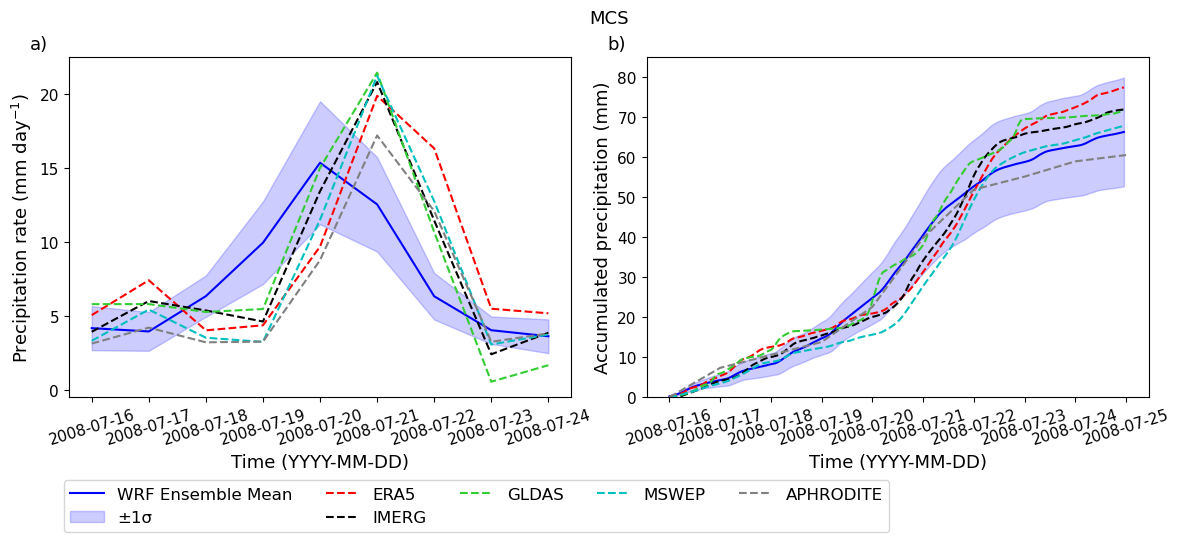

In [27]:
# Time series
nrows, ncols = 1,2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=13, y=1.07)

#precipitation rate
axs[0].plot(time, avg_wrf, label='WRF Ensemble Mean', color='blue')
axs[0].fill_between(time, avg_wrf - std_wrf, avg_wrf + std_wrf,
                 color='blue', alpha=0.2, label='±1σ')
axs[0].plot(days, ravgdailyc[6], color='r', linestyle='dashed' ,label='ERA5')
axs[0].plot(days, ravgdailyc[7], color='k', linestyle='dashed', label='IMERG')
axs[0].plot(days, ravgdailyc[8], color='limegreen', linestyle='dashed', label='GLDAS')
axs[0].plot(days, ravgdailyc[9], color='c', linestyle='dashed', label='MSWEP')
axs[0].plot(days, mean_rprAPHROc.values, color='grey', linestyle='dashed', label='APHRODITE')

axs[0].tick_params(axis='y', labelsize=11)
axs[0].tick_params(axis='x', rotation=17, labelsize=11)
axs[0].set_title('a)', fontsize=13, x=-0.06)
axs[0].set_ylabel(r'Precipitation rate (mm day$^{-1}$)', fontsize=13)
axs[0].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)


#accumulated precipitation
plt.plot(actime, acavg_wrf, label='WRF Ensemble Mean', color='blue')
plt.fill_between(actime, acavg_wrf - acstd_wrf, acavg_wrf + acstd_wrf,
                 color='blue', alpha=0.2, label='±1σ')
axs[1].plot(ds_prERA.time, racpr[6], color='r', linestyle='dashed', label='ERA5')
axs[1].plot(ds_prERA.time, rac_prIMERGc, linestyle='dashed',color='k', label='IMERG')
axs[1].plot(ds_prERA.time, racpr_GLDASc, linestyle='dashed',color='limegreen', label='GLDAS')
axs[1].plot(ds_prERA.time, racpr_MSWEPc, linestyle='dashed',color='c', label='MSWEP')
axs[1].plot(racpr_APHROc.time, racpr_APHROc, linestyle='dashed',color='grey', label='APHRODITE')

axs[1].legend(loc='upper right', ncol=5, bbox_to_anchor=(0.5, -0.22), fontsize=12)
axs[1].set_ylim(0, 85)
axs[1].tick_params(axis='y', labelsize=11)
axs[1].tick_params(axis='x', rotation=17, labelsize=11)
axs[1].set_title('b)', fontsize=13, x=-0.06)
axs[1].set_ylabel('Accumulated precipitation (mm)', fontsize=13)
axs[1].set_xlabel(r'Time (YYYY-MM-DD)', fontsize=13)
plt.tight_layout()
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.15, hspace=0.25)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-ens-time-mcs.png', dpi=400, bbox_inches='tight');

## Precipitation ensemble maps

In [28]:
# Mean precipitation rate over XTIME
avgt_wrf = (meant_rprthoc + meant_rprmorc + meant_rprcamc + meant_rprylinc + meant_rprwdm7c + meant_rprwdm6c)/6

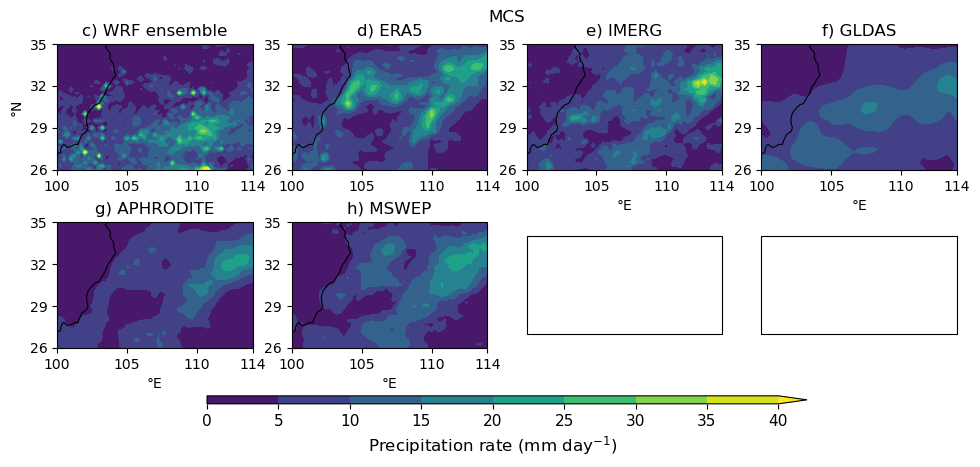

In [29]:
# observation based and reanalysis datasets
ds = [avgt_wrf, meant_prERAc, meant_rprIMERGc, meant_rprGLDASc, meant_rprAPHROc, meant_rprMSWEPc]
titl=['c) WRF ensemble', 'd) ERA5', 'e) IMERG', 'f) GLDAS', 'g) APHRODITE','h) MSWEP']
#colormap
cmap  = plt.cm.viridis 
#set clevels
clevs=np.arange(0,41,5)

#create figure
nrows, ncols = 2,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10,4))
axs = axs.flatten()
fig.suptitle('MCS', fontsize=12, y=0.99)


#set anomalies
for i in range (0, 6):
 cs = axs[i].contourf(ds[0].longitude.values, ds[0].latitude.values, ds[i], clevs, cmap=cmap, extend='max')
 axs[i].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.8)
 axs[i].set_title(f'{(3*titl)[i]}', fontsize = 12) 
 axs[i].set_xticks([100,105,110,114])
 axs[i].set_yticks([26,29,32,35])
 axs[i].tick_params(axis='x', labelsize=10)  
 axs[i].tick_params(axis='y', labelsize=10)
 axs[0].set_ylabel('°N', fontsize=10)
 axs[i+2].set_xlabel('°E', fontsize=10)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.005, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'Precipitation rate (mm day$^{-1}$)', fontsize = 12)
cbar.ax.tick_params(labelsize=11)
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)

plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/p-ens-maps-mcs.png', dpi=400, bbox_inches='tight');